In [1]:
# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"winocas","key":"d0f593e1caca70735e117d0f7cec5748"}'}

In [2]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json #permission warning 방지

In [3]:
# ! kaggle datasets download -d iamprateek/wallmart-sales-forecast-datasets

  0% 0.00/3.36M [00:00<?, ?B/s]
100% 3.36M/3.36M [00:00<00:00, 55.5MB/s]


In [4]:
!unzip \*.zip  && rm *.zip # 압축해제

Archive:  wallmart-sales-forecast-datasets.zip
  inflating: features.csv            
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               


# 모델링

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
feat = pd.read_csv('features.csv')

In [7]:
def prepro_train(x) :
    X = x.copy()
    X = X[X['Weekly_Sales'] >0] # target값 >0 인 것들만 사용
    X = X.merge(feat,  how = 'left').merge(stores,  how = 'left') # 추가로 주어진 데이터들 병합해 사용

    X['Year'] = pd.to_datetime(X['Date']).dt.year # Date 중 연도만 따로 추출
    X['Month'] = pd.to_datetime(X['Date']).dt.month # Date 중 월만 따로 추출

    X.drop(columns=['Date', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace = True) # 사용하지 않을 변수 삭제

    X = pd.get_dummies(X, columns = ['Type']) # object 변수형 가진 'Type'을 더미변수화
    return X

In [8]:
def prepro_test(x) :
    X = x.copy()

    X = X.merge(feat,  how = 'left').merge(stores,  how = 'left')    # 추가로 주어진 데이터들 병합해 사용

    X['Year'] = pd.to_datetime(X['Date']).dt.year # Date 중 연도만 따로 추출
    X['Month'] = pd.to_datetime(X['Date']).dt.month # Date 중 월만 따로 추출

    X.drop(columns=['Date', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace = True) # 사용하지 않을 변수 삭제

    X = pd.get_dummies(X, columns = ['Type'])# object 변수형 가진 'Type'을 더미변수화
    return X

In [9]:
train1 = prepro_train(train)
test1 = prepro_test(test)

In [10]:
train1

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Year,Month,Type_A,Type_B,Type_C
0,1,1,24924.50,False,42.31,2.572,211.096358,8.106,151315,2010,2,1,0,0
1,1,1,46039.49,True,38.51,2.548,211.242170,8.106,151315,2010,2,1,0,0
2,1,1,41595.55,False,39.93,2.514,211.289143,8.106,151315,2010,2,1,0,0
3,1,1,19403.54,False,46.63,2.561,211.319643,8.106,151315,2010,2,1,0,0
4,1,1,21827.90,False,46.50,2.625,211.350143,8.106,151315,2010,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420207,45,98,508.37,False,64.88,3.997,192.013558,8.684,118221,2012,9,0,1,0
420208,45,98,628.10,False,64.89,3.985,192.170412,8.667,118221,2012,10,0,1,0
420209,45,98,1061.02,False,54.47,4.000,192.327265,8.667,118221,2012,10,0,1,0
420210,45,98,760.01,False,56.47,3.969,192.330854,8.667,118221,2012,10,0,1,0


In [11]:
test1

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Year,Month,Type_A,Type_B,Type_C
0,1,1,False,55.32,3.386,223.462779,6.573,151315,2012,11,1,0,0
1,1,1,False,61.24,3.314,223.481307,6.573,151315,2012,11,1,0,0
2,1,1,False,52.92,3.252,223.512911,6.573,151315,2012,11,1,0,0
3,1,1,True,56.23,3.211,223.561947,6.573,151315,2012,11,1,0,0
4,1,1,False,52.34,3.207,223.610984,6.573,151315,2012,11,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,False,76.05,3.639,NaN,NaN,118221,2013,6,0,1,0
115060,45,98,False,77.50,3.614,NaN,NaN,118221,2013,7,0,1,0
115061,45,98,False,79.37,3.614,NaN,NaN,118221,2013,7,0,1,0
115062,45,98,False,82.84,3.737,NaN,NaN,118221,2013,7,0,1,0


## 데이터셋 분할 

In [12]:
from sklearn.model_selection import train_test_split
train2, val1 = train_test_split(train1, train_size=0.80, test_size=0.20, random_state=1)
train2.shape, val1.shape, test1.shape

((336169, 14), (84043, 14), (115064, 13))

In [13]:
target = 'Weekly_Sales'
feature =  train2.columns.drop([target])

X_train = train2[feature]
y_train = train2[target]

X_val = val1[feature]
y_val = val1[target]

X_test = test1[feature]

RandomForest default

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

In [23]:
pipe = make_pipeline(
    SimpleImputer(),
    RandomForestRegressor(random_state=2)
)
pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)

0.9664203483899002

RandomForest + log tranformation

In [14]:
pipe = make_pipeline(
    SimpleImputer(),
    RandomForestRegressor(random_state=2)
)

tt = TransformedTargetRegressor(regressor=pipe,
                                func=np.log1p, inverse_func=np.expm1)

tt.fit(X_train, y_train)
tt.score(X_val, y_val)

0.9607345166439649

xgboost default

In [27]:
from xgboost import XGBRegressor

pipe = make_pipeline(
    SimpleImputer(), 
    XGBRegressor(objective='reg:squarederror'
                  , random_state=2
                  , n_jobs=-1
                 )
)
pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)

0.7423244352668155

In [28]:
from xgboost import XGBRegressor

pipe = make_pipeline(
    XGBRegressor(objective='reg:squarederror'
                  , random_state=2
                  , n_jobs=-1
                 )
)
pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)

0.7423244352668155

xgboost + log transformation

In [17]:
from xgboost import XGBRegressor

pipe = make_pipeline(
    SimpleImputer(),
    XGBRegressor(objective='reg:squarederror'
                  , random_state=2
                  , n_jobs=-1)
)
tt = TransformedTargetRegressor(regressor=pipe,
                                func=np.log1p, inverse_func=np.expm1)

tt.fit(X_train, y_train)
tt.score(X_val, y_val)

0.5299571453417689

In [29]:
pipe = make_pipeline(
    XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
)
pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)

0.9404280485923292

lightgbm default

In [24]:
from lightgbm import LGBMRegressor

pipe = make_pipeline(
    SimpleImputer(),
    LGBMRegressor(random_state = 2)
)
pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)

0.9081147931810626

lightgbm + log transformation

In [19]:
pipe = make_pipeline(
    SimpleImputer(),
    LGBMRegressor(random_state = 2)
)

tt = TransformedTargetRegressor(regressor=pipe,
                                func=np.log1p, inverse_func=np.expm1)

tt.fit(X_train, y_train)
tt.score(X_val, y_val)

0.7978452280223426

In [ ]:
encoder = SimpleImputer()
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train), columns = X_train.columns) # 뒤에 pdp plot에 오류 나지 않도록 dataframe 형태로!
X_val_encoded = pd.DataFrame(encoder.transform(X_val), columns = X_val.columns) 

lgbm = LGBMRegressor(
    n_estimators=5000,
    objective='regression', # default
    learning_rate=0.5,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

lgbm.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50)

In [31]:
y_pred = lgbm.predict(X_val_encoded)

In [33]:
from sklearn.metrics import r2_score
print('R^2 :', r2_score(y_val, y_pred, multioutput='variance_weighted'))

R^2 : 0.9753472831830211


In [44]:
lgbm.score(X_val_encoded, y_pred)

1.0

In [34]:
lgbm

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.5, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=5000, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

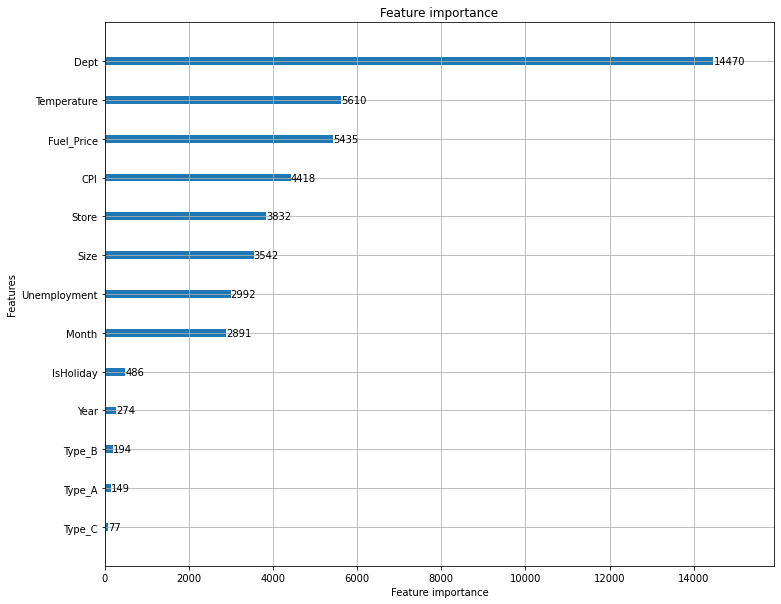

In [41]:
from lightgbm import plot_importance

plot_importance(lgbm,
                figsize = (12,10));